In [1]:
import pandas as pd
import numpy as np
import os

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [2]:
base_dir = os.path.dirname(os.getcwd())
movies_path = os.path.join(base_dir, 'data', 'Movies_final.csv')
df = pd.read_csv(movies_path)
df.info()
df.head(87000)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86493 entries, 0 to 86492
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    86493 non-null  int64  
 1   title                 86493 non-null  object 
 2   vote_average          86493 non-null  float64
 3   vote_count            86493 non-null  int64  
 4   status                86493 non-null  object 
 5   release_date          86427 non-null  object 
 6   revenue               86493 non-null  int64  
 7   runtime               86493 non-null  int64  
 8   adult                 86493 non-null  bool   
 9   backdrop_path         70442 non-null  object 
 10  budget                86493 non-null  int64  
 11  homepage              17774 non-null  object 
 12  imdb_id               86467 non-null  object 
 13  original_language     86493 non-null  object 
 14  original_title        86493 non-null  object 
 15  overview           

,id,title,vote_average,vote_count,status,release_date,revenue,runtime,adult,backdrop_path,budget,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,tagline,genres,production_companies,production_countries,spoken_languages,keywords,movieId,Directors,Cast,StarActors
0,27205,Inception,8.364,34495,Released,2010-07-15,825532764,148,False,/8ZTVqvKDQ8emSGUEMjsS4yHAwrp.jpg,160000000,https://www.warnerbros.com/movies/inception,tt1375666,en,Inception,"Cobb, a skilled thief who commits corporate es...",83.952,/oYuLEt3zVCKq57qu2F8dT7NIa6f.jpg,Your mind is the scene of the crime.,"Action, Science Fiction, Adventure","Legendary Pictures, Syncopy, Warner Bros. Pict...","United Kingdom, United States of America","English, French, Japanese, Swahili","rescue, mission, dream, airplane, paris, franc...",79132,Christopher Nolan,"Leonardo DiCaprio, Joseph Gordon-Levitt, Ellio...","Leonardo DiCaprio, Joseph Gordon-Levitt, Ellio..."
1,157336,Interstellar,8.417,32571,Released,2014-11-05,701729206,169,False,/pbrkL804c8yAv3zBZR4QPEafpAR.jpg,165000000,http://www.interstellarmovie.net/,tt0816692,en,Interstellar,The adventures of a group of explorers who mak...,140.241,/gEU2QniE6E77NI6lCU6MxlNBvIx.jpg,Mankind was born on Earth. It was never meant ...,"Adventure, Drama, Science Fiction","Legendary Pictures, Syncopy, Lynda Obst Produc...","United Kingdom, United States of America",English,"rescue, future, spacecraft, race against time,...",109487,Christopher Nolan,"Matthew McConaughey, Anne Hathaway, Jessica Ch...","Matthew McConaughey, Anne Hathaway, Jessica Ch..."
2,155,The Dark Knight,8.512,30619,Released,2008-07-16,1004558444,152,False,/nMKdUUepR0i5zn0y1T4CsSB5chy.jpg,185000000,https://www.warnerbros.com/movies/dark-knight/,tt0468569,en,The Dark Knight,Batman raises the stakes in his war on crime. ...,130.643,/qJ2tW6WMUDux911r6m7haRef0WH.jpg,Welcome to a world without rules.,"Drama, Action, Crime, Thriller","DC Comics, Legendary Pictures, Syncopy, Isobel...","United Kingdom, United States of America","English, Mandarin","joker, sadism, chaos, secret identity, crime f...",58559,Christopher Nolan,"Christian Bale, Heath Ledger, Aaron Eckhart, M...","Christian Bale, Heath Ledger, Aaron Eckhart"
3,19995,Avatar,7.573,29815,Released,2009-12-15,2923706026,162,False,/vL5LR6WdxWPjLPFRLe133jXWsh5.jpg,237000000,https://www.avatar.com/movies/avatar,tt0499549,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",79.932,/kyeqWdyUXW608qlYkRqosgbbJyK.jpg,Enter the world of Pandora.,"Action, Adventure, Fantasy, Science Fiction","Dune Entertainment, Lightstorm Entertainment, ...","United States of America, United Kingdom","English, Spanish","future, society, culture clash, space travel, ...",72998,James Cameron,"Sam Worthington, Zoe Saldaña, Sigourney Weaver...","Sam Worthington, Zoe Saldaña, Sigourney Weaver"
4,24428,The Avengers,7.710,29166,Released,2012-04-25,1518815515,143,False,/9BBTo63ANSmhC4e6r62OJFuK2GL.jpg,220000000,https://www.marvel.com/movies/the-avengers,tt0848228,en,The Avengers,When an unexpected enemy emerges and threatens...,98.082,/RYMX2wcKCBAr24UyPD7xwmjaTn.jpg,Some assembly required.,"Science Fiction, Action, Adventure",Marvel Studios,United States of America,"English, Hindi, Russian","new york city, superhero, shield, based on com...",89745,Joss Whedon,"Robert Downey Jr., Chris Evans, Scarlett Johan...","Robert Downey Jr., Chris Evans"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86488,806914,Avicenna,0.000,0,Released,1957-12-09,0,92,False,NaN,0,NaN,tt0312400,ru,Авиценна,"The film is dedicated to the philosopher, doct...",0.647,/kGe8cpnOgkiIfQWFezgED9aRfH0.jpg,"Biography, Drama, History","Drama, History",Tashkent Studios,Soviet Union,Russian,"biography, historical drama, avitsenna",286353,Kamil Yarmatov,"Marat Aripov, Tulkun Tadzhiyev, Abbas Bakirov,...","Marat Aripov, Tulkun Tadzhiyev, Abbas Bakirov"
86489,273772,Black Nation,0.000,0,Released,

In [3]:
def count_zeros_and_empty(df):
    count_dict = {}

    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            zero_count = (df[col] == 0).sum()
            count_dict[col] = {'zeros': zero_count}

        elif pd.api.types.is_string_dtype(df[col]):
            empty_count = (df[col] == '').sum()
            count_dict[col] = {'empty_strings': empty_count}

    return count_dict

count_result = count_zeros_and_empty(df)
print(count_result)


{'id': {'zeros': 0}, 'title': {'empty_strings': 0}, 'vote_average': {'zeros': 2576}, 'vote_count': {'zeros': 2566}, 'status': {'empty_strings': 0}, 'revenue': {'zeros': 73454}, 'runtime': {'zeros': 1262}, 'adult': {'zeros': 86474}, 'budget': {'zeros': 71884}, 'original_language': {'empty_strings': 0}, 'original_title': {'empty_strings': 0}, 'popularity': {'zeros': 0}, 'movieId': {'zeros': 0}}


# Transformacja i dopasowanie do ratings

In [4]:
ratings_path = os.path.join(base_dir, 'data', 'ratings_groupped_ids.parquet')
df_ratings = pd.read_parquet(ratings_path)

In [5]:
# CHECKING movieID coverage

movie_ids_all = set(df['movieId'])

movie_ids_ratings = set(
    m for pos, neg in zip(df_ratings['pos'], df_ratings['neg'])
    for m in list(pos) + list(neg)
)
valid_movie_ids = movie_ids_all & movie_ids_ratings

print(f"Liczba wspólnych movieId: {len(valid_movie_ids)}")

df_ratings['pos'] = df_ratings['pos'].apply(lambda lst: [m for m in lst if m in valid_movie_ids])
df_ratings['neg'] = df_ratings['neg'].apply(lambda lst: [m for m in lst if m in valid_movie_ids])
df_ratings = df_ratings[(df_ratings['pos'].str.len() > 0) | (df_ratings['neg'].str.len() > 0)]

df = df[df['movieId'].isin(valid_movie_ids)]

Liczba wspólnych movieId: 82932


In [6]:
df = df.reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82932 entries, 0 to 82931
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    82932 non-null  int64  
 1   title                 82932 non-null  object 
 2   vote_average          82932 non-null  float64
 3   vote_count            82932 non-null  int64  
 4   status                82932 non-null  object 
 5   release_date          82873 non-null  object 
 6   revenue               82932 non-null  int64  
 7   runtime               82932 non-null  int64  
 8   adult                 82932 non-null  bool   
 9   backdrop_path         68155 non-null  object 
 10  budget                82932 non-null  int64  
 11  homepage              17418 non-null  object 
 12  imdb_id               82907 non-null  object 
 13  original_language     82932 non-null  object 
 14  original_title        82932 non-null  object 
 15  overview           

# Początkowe usunięcie niepotrzebnych kolumn

In [7]:
df = df.drop(columns=['adult', 'homepage', 'backdrop_path', 'imdb_id', 'poster_path', 'id'])
df = df[df['status'] == 'Released']
df = df.drop(columns=['status'])
df = df.reset_index(drop=True)

In [8]:
print(df.info())

df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82918 entries, 0 to 82917
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   title                 82918 non-null  object 
 1   vote_average          82918 non-null  float64
 2   vote_count            82918 non-null  int64  
 3   release_date          82863 non-null  object 
 4   revenue               82918 non-null  int64  
 5   runtime               82918 non-null  int64  
 6   budget                82918 non-null  int64  
 7   original_language     82918 non-null  object 
 8   original_title        82918 non-null  object 
 9   overview              82129 non-null  object 
 10  popularity            82918 non-null  float64
 11  tagline               38018 non-null  object 
 12  genres                81442 non-null  object 
 13  production_companies  69882 non-null  object 
 14  production_countries  76632 non-null  object 
 15  spoken_languages   

,title,vote_average,vote_count,release_date,revenue,runtime,budget,original_language,original_title,overview,popularity,tagline,genres,production_companies,production_countries,spoken_languages,keywords,movieId,Directors,Cast,StarActors
0,Inception,8.364,34495,2010-07-15,825532764,148,160000000,en,Inception,"Cobb, a skilled thief who commits corporate es...",83.952,Your mind is the scene of the crime.,"Action, Science Fiction, Adventure","Legendary Pictures, Syncopy, Warner Bros. Pict...","United Kingdom, United States of America","English, French, Japanese, Swahili","rescue, mission, dream, airplane, paris, franc...",79132,Christopher Nolan,"Leonardo DiCaprio, Joseph Gordon-Levitt, Ellio...","Leonardo DiCaprio, Joseph Gordon-Levitt, Ellio..."
1,Interstellar,8.417,32571,2014-11-05,701729206,169,165000000,en,Interstellar,The adventures of a group of explorers who mak...,140.241,Mankind was born on Earth. It was never meant ...,"Adventure, Drama, Science Fiction","Legendary Pictures, Syncopy, Lynda Obst Produc...","United Kingdom, United States of America",English,"rescue, future, spacecraft, race against time,...",109487,Christopher Nolan,"Matthew McConaughey, Anne Hathaway, Jessica Ch...","Matthew McConaughey, Anne Hathaway, Jessica Ch..."
2,The Dark Knight,8.512,30619,2008-07-16,1004558444,152,185000000,en,The Dark Knight,Batman raises the stakes in his war on crime. ...,130.643,Welcome to a world without rules.,"Drama, Action, Crime, Thriller","DC Comics, Legendary Pictures, Syncopy, Isobel...","United Kingdom, United States of America","English, Mandarin","joker, sadism, chaos, secret identity, crime f...",58559,Christopher Nolan,"Christian Bale, Heath Ledger, Aaron Eckhart, M...","Christian Bale, Heath Ledger, Aaron Eckhart"


# Inzynieria cech

In [9]:
# IMDB WEIGHTED AVERAGE

C = df['vote_average'].mean()
m = 304 # TOP 10 %
# m = 99 # TOP 20 %

def weighted_rating(row, m=m, C=C):
    v = row['vote_count']
    R = row['vote_average']
    return (R * v + C * m) / (v + m) if v > 0 else 0

df['vote_score'] = df.apply(weighted_rating, axis=1)

In [10]:
# BLOCKBUSTER

budget_threshold = df['revenue'].quantile(0.95)
popularity_threshold = df['popularity'].quantile(0.90)
vote_score_threshold = df['vote_score'].quantile(0.90)

df['if_blockbuster'] = np.where(
    (df['vote_score'] >= vote_score_threshold) &
    (df['revenue'] >= budget_threshold) &
    (df['popularity'] >= popularity_threshold),
    1,
    0
)

print(df[['title', 'revenue', 'popularity', 'vote_score', 'if_blockbuster']].head())


             title     revenue  popularity  vote_score  if_blockbuster
0        Inception   825532764      83.952    8.342378               1
1     Interstellar   701729206     140.241    8.393622               1
2  The Dark Knight  1004558444     130.643    8.486213               1
3           Avatar  2923706026      79.932    7.556002               1
4     The Avengers  1518815515      98.082    7.691214               1


In [11]:
# HIGHLY WATCHED

df['highly_watched'] = np.where(
    ((df['popularity'] >= popularity_threshold) & (df['vote_count'] >= df['vote_count'].quantile(0.80))),
    1,
    0
)

print(df[['title', 'budget', 'popularity', 'vote_count', 'vote_score', 'if_blockbuster', 'highly_watched']].head())

             title     budget  popularity  vote_count  vote_score  \
0        Inception  160000000      83.952       34495    8.342378   
1     Interstellar  165000000     140.241       32571    8.393622   
2  The Dark Knight  185000000     130.643       30619    8.486213   
3           Avatar  237000000      79.932       29815    7.556002   
4     The Avengers  220000000      98.082       29166    7.691214   

   if_blockbuster  highly_watched  
0               1               1  
1               1               1  
2               1               1  
3               1               1  
4               1               1  


In [12]:
# YEAR AND DECADES

df['release_year'] = pd.to_datetime(df['release_date'], errors='coerce').dt.year

# BECAUSE WE HAVE 9 MOVIES <1890 WE CHANGE THEIR YEAR TO 1890
df.loc[df['release_year'] < 1890, 'release_year'] = 1890
df['decade'] = pd.cut(df['release_year'], bins=range(1890, 2031, 10), right=False)

In [13]:
# HIGHLY RATED WITH DIVISION ON DECADES

vote_score_thresholds = df.groupby('decade')['vote_score'].quantile(0.90)

def is_highly_rated(row):
    decade = row['decade']
    score = row['vote_score']
    count = row['vote_count']

    if pd.isna(decade) or pd.isna(score) or pd.isna(count):
        return 0

    threshold = vote_score_thresholds.get(decade, np.inf)

    # To block low_voted movies
    if count >= 50 and score >= threshold:
        return 1
    return 0

df['highly_rated'] = df.apply(is_highly_rated, axis=1)

C:\Users\matimathew\AppData\Local\Temp\ipykernel_4696\2878591845.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  vote_score_thresholds = df.groupby('decade')['vote_score'].quantile(0.90)


In [14]:
# COMBINING VOTE_SCORE AND POPULARITY
# from sklearn.preprocessing import MinMaxScaler
#
# scaler = MinMaxScaler()
# df[['scaled_votes', 'scaled_popularity']] = scaler.fit_transform(df[['vote_count', 'popularity']])
#
# df['engagement_score'] = 0.6 * df['scaled_votes'] + 0.4 * df['scaled_popularity']

from sklearn.preprocessing import QuantileTransformer

quantile = QuantileTransformer(output_distribution='normal', random_state=42, n_quantiles=1000)

df[['scaled_votes', 'scaled_popularity']] = quantile.fit_transform(df[['vote_count', 'popularity']])

df['engagement_score'] = 0.6 * df['scaled_votes'] + 0.4 * df['scaled_popularity']


In [15]:
# WE GET ENGLISH STOPWORDS
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\matimathew\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [16]:
# SEMANTIC_KEYWORDS (MERGE OF TAGLINE + KEYWORDS)

import re
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def clean_and_tokenize_tagline(tagline):
    if pd.isna(tagline):
        return []
    words = re.sub(r'[^\w\s]', '', tagline.lower()).split()
    filtered = [w for w in words if w not in stop_words]
    return filtered

def combine_keywords_and_tagline(row):
    kw = row['keywords'] if pd.notna(row['keywords']) else ''
    tag_tokens = clean_and_tokenize_tagline(row['tagline'])
    kw_tokens = [k.strip().lower() for k in kw.split(',') if k]
    combined = kw_tokens + tag_tokens
    return list(set(combined))

df['semantic_keywords'] = df.apply(combine_keywords_and_tagline, axis=1)

In [17]:
# CAST IMPORTANCE AND TOP ACTORS

from collections import defaultdict

df['Cast'] = df['Cast'].fillna("").apply(lambda x: x.split(', ') if isinstance(x, str) else [])
df['Cast'] = df['Cast'].apply(lambda x: [] if x == [''] else x)

actor_engagement = defaultdict(list)

for _, row in df.iterrows():
    cast = row['Cast']
    engagement = row.get('engagement_score', np.nan)
    if not isinstance(cast, list) or pd.isna(engagement):
        continue
    for actor in cast:
        actor_engagement[actor].append(engagement)

actor_score = {
    actor: np.mean(scores) * np.log1p(len(scores))
    for actor, scores in actor_engagement.items()
}

# TO DEFINE PARAMETERS (SEEMS TO HAVE BEST RESULTS WITH 5)
TOP_N = 5
MAX_CAST_LEN = df['Cast'].apply(len).max()

def compute_cast_importance_with_names(cast):
    if not cast or len(cast) == 0:
        return pd.Series([0.0, []])
    scores = sorted([(actor, actor_score.get(actor, 0)) for actor in cast], key=lambda x: x[1], reverse=True)
    top_scores = scores[:TOP_N]
    mean_score = np.mean([s[1] for s in top_scores]) if top_scores else 0.0
    weight = len(top_scores) / MAX_CAST_LEN if MAX_CAST_LEN > 0 else 1.0
    importance = mean_score * weight
    top_actors = [s[0] for s in top_scores]
    return pd.Series([importance, top_actors])

df[['cast_importance', 'top_cast_members']] = df['Cast'].apply(compute_cast_importance_with_names)

In [18]:
df.tail(1000)

,title,vote_average,vote_count,release_date,revenue,runtime,budget,original_language,original_title,overview,popularity,tagline,genres,production_companies,production_countries,spoken_languages,keywords,movieId,Directors,Cast,StarActors,vote_score,if_blockbuster,highly_watched,release_year,decade,highly_rated,scaled_votes,scaled_popularity,engagement_score,semantic_keywords,cast_importance,top_cast_members
81918,Chris Elliott's FDR -- A One-Man Show,0.0,0,1987-12-26,0,30,0,en,Chris Elliott's FDR -- A One-Man Show,"Chris Elliot plays FDR in his live ""One Man Sh...",0.849,NaN,"Comedy, Documentary, TV Movie","HBO, Cinemax",United States of America,NaN,"one-man show, stand-up comedy, fictional biogr...",246030,Matt Wickline,"[Chris Elliott, Bob Elliott, Mark Allen, Wolfg...","Chris Elliott, Bob Elliott, Mark Allen",0.0,0,0,1987.0,"[1980, 1990)",0,-5.199338,-1.369357,-3.667345,"[fictional biography, one-man show, stand-up c...",-0.705445,"[Chris Elliott, Bob Elliott, Wolfgang Zilzer, ..."
81919,AirBNB Dream or Nightmare,0.0,0,2016-09-21,0,47,0,en,AirBNB Dream or Nightmare,"Airbnb has become a useful tool for millions, ...",0.601,AirBNB: Dream or Nightmare?,"TV Movie, Documentary",NaN,NaN,English,airbnb,216727,NaN,[],NaN,0.0,0,0,2016.0,"[2010, 2020)",0,-5.199338,-1.715172,-3.805671,"[dream, airbnb, nightmare]",0.000000,[]
81920,Vesenniye perevyortyshi,0.0,0,1974-10-21,0,85,0,ru,Весенние перевертыши,A story of a thirteen year old boy who lives i...,0.600,NaN,"Romance, Family, Drama",Lenfilm,Soviet Union,Russian,NaN,202379,Grigoriy Aronov,"[Roman Madyanov, Larisa Malevannaya, Nikolay P...","Roman Madyanov, Larisa Malevannaya, Nikolay Pe...",0.0,0,0,1974.0,"[1970, 1980)",0,-5.199338,-5.199338,-5.199338,[],-1.124434,"[Nikolay Grinko, Roman Madyanov, Larisa Maleva..."
81921,Burning,0.0,0,2002-01-01,0,7,0,en,Burning,"""Your life is like a candle burning. Whether y...",0.600,NaN,NaN,NaN,Canada,No Language,NaN,268180,NaN,[],NaN,0.0,0,0,2002.0,"[2000, 2010)",0,-5.199338,-5.199338,-5.199338,[],0.000000,[]
81922,Killers of the Flower Moon,0.0,0,2023-10-18,0,206,170000000,en,Killers of the Flower Moon,When oil is discovered in 1920s Oklahoma under...,90.719,Greed is an animal that hungers for blood.,"Crime, Drama, Thriller","Appian Way, Imperative Entertainment, Sikelia ...",United States of America,English,"husband wife relationship, based on novel or b...",266002,Martin Scorsese,"[Leonardo DiCaprio, Robert De Niro, Lily Glads...","Leonardo DiCaprio, Robert De Niro, Lily Gladstone",0.0,0,0,2023.0,"[2020, 2030)",0,-5.199338,2.789354,-2.003861,"[courtroom, murder, greed, manipulation, osage...",2.634968,"[Leonardo DiCaprio, Robert De Niro, Jesse Plem..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82913,Time Again,0.0,0,2011-07-26,0,82,0,en,Time Again,We have all made mistakes. Little white lies ...,0.600,"That was now, this is then.",NaN,NaN,NaN,NaN,NaN,160535,Ray Karwel,"[Scott F. Evans, John T. Woods, Angela Rachell...","Scott F. Evans, John T. Woods, Angela Rachelle",0.0,0,0,2011.0,"[2010, 2020)",0,-5.199338,-5.199338,-5.199338,[],-1.266967,"[Braxton Davis, John T. Woods, Gigi Perreau, R..."
82914,Avicenna,0.0,0,1957-12-09,0,92,0,ru,Авиценна,"The film is dedicated to the philosopher, doct...",0.647,"Biography, Drama, History","Drama, History",Tashkent Studios,Soviet Union,Russian,"biography, historical drama, avitsenna",286353,Kamil Yarmatov,"[Marat Aripov, Tulkun Tadzhiyev, Abbas Bakirov...","Marat Aripov, Tulkun Tadzhiyev, Abbas Bakirov",0.0,0,0,1957.0,"[1950, 1960)",0,-5.199338,-1.646639,-3.778258,"[history, drama, avitsenna, historical drama, ...",-1.311889,"[Marat Aripov, Tulkun Tadzhiyev, Mukhamejan Ka..."
82915,Black Nation,0.0,0,2008-01-01,0,62,0,en,Black Nation,Black Nation is a compelling film that takes a...,0.600,NaN,Documentary,XiveTV,United States of America,English,NaN,272047,NaN,[],NaN,0.0,0,0,2008.0,"[2000, 2010)",0,-5.199338,-5.1993

In [19]:
# DIRECTORS SCORE AND BEST DIRECTORS

df['Directors'] = df['Directors'].fillna("").apply(lambda x: x.split(', ') if isinstance(x, str) else [])
df['Directors'] = df['Directors'].apply(lambda x: [] if x == [''] else x)

director_engagement_sum = defaultdict(float)
director_film_count = defaultdict(int)

for idx, row in df.iterrows():
    engagement = row['engagement_score']
    for director in row['Directors']:
        director_engagement_sum[director] += engagement
        director_film_count[director] += 1

director_score = {
    director: total_engagement / np.log1p(director_film_count[director])
    for director, total_engagement in director_engagement_sum.items()
}

# TO DEFINE PARAMETERS (SEEMS TO HAVE BEST RESULTS WITH 3)
TOP_N_DIRECTORS = 3

def compute_director_importance_with_names(directors):
    if not directors or len(directors) == 0:
        return pd.Series([0.0, []])
    scores = sorted([(d, director_score.get(d, 0)) for d in directors], key=lambda x: x[1], reverse=True)
    top_scores = scores[:TOP_N_DIRECTORS]
    mean_score = np.mean([s[1] for s in top_scores]) if top_scores else 0.0
    return pd.Series([mean_score, [s[0] for s in top_scores]])

df[['director_score', 'top_directors']] = df['Directors'].apply(compute_director_importance_with_names)

In [20]:
df.head(1000)

,title,vote_average,vote_count,release_date,revenue,runtime,budget,original_language,original_title,overview,popularity,tagline,genres,production_companies,production_countries,spoken_languages,keywords,movieId,Directors,Cast,StarActors,vote_score,if_blockbuster,highly_watched,release_year,decade,highly_rated,scaled_votes,scaled_popularity,engagement_score,semantic_keywords,cast_importance,top_cast_members,director_score,top_directors
0,Inception,8.364,34495,2010-07-15,825532764,148,160000000,en,Inception,"Cobb, a skilled thief who commits corporate es...",83.952,Your mind is the scene of the crime.,"Action, Science Fiction, Adventure","Legendary Pictures, Syncopy, Warner Bros. Pict...","United Kingdom, United States of America","English, French, Japanese, Swahili","rescue, mission, dream, airplane, paris, franc...",79132,[Christopher Nolan],"[Leonardo DiCaprio, Joseph Gordon-Levitt, Elli...","Leonardo DiCaprio, Joseph Gordon-Levitt, Ellio...",8.342378,1,1,2010.0,"[2010, 2020)",1,5.199338,2.735704,4.213884,"[kidnapping, allegory, manipulation, mission, ...",2.892747,"[Leonardo DiCaprio, Tom Hardy, Joseph Gordon-L...",14.118837,[Christopher Nolan]
1,Interstellar,8.417,32571,2014-11-05,701729206,169,165000000,en,Interstellar,The adventures of a group of explorers who mak...,140.241,Mankind was born on Earth. It was never meant ...,"Adventure, Drama, Science Fiction","Legendary Pictures, Syncopy, Lynda Obst Produc...","United Kingdom, United States of America",English,"rescue, future, spacecraft, race against time,...",109487,[Christopher Nolan],"[Matthew McConaughey, Anne Hathaway, Jessica C...","Matthew McConaughey, Anne Hathaway, Jessica Ch...",8.393622,1,1,2014.0,"[2010, 2020)",1,5.199338,2.973990,4.309199,"[2060s, future, complicated, time warp, earth,...",2.816915,"[Anne Hathaway, Matthew McConaughey, Jessica C...",14.118837,[Christopher Nolan]
2,The Dark Knight,8.512,30619,2008-07-16,1004558444,152,185000000,en,The Dark Knight,Batman raises the stakes in his war on crime. ...,130.643,Welcome to a world without rules.,"Drama, Action, Crime, Thriller","DC Comics, Legendary Pictures, Syncopy, Isobel...","United Kingdom, United States of America","English, Mandarin","joker, sadism, chaos, secret identity, crime f...",58559,[Christopher Nolan],"[Christian Bale, Heath Ledger, Aaron Eckhart, ...","Christian Bale, Heath Ledger, Aaron Eckhart",8.486213,1,1,2008.0,"[2000, 2010)",1,5.199338,2.947645,4.298661,"[crime fighter, world, anti villain, vigilante...",3.009792,"[Christian Bale, Gary Oldman, Morgan Freeman, ...",14.118837,[Christopher Nolan]
3,Avatar,7.573,29815,2009-12-15,2923706026,162,237000000,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",79.932,Enter the world of Pandora.,"Action, Adventure, Fantasy, Science Fiction","Dune Entertainment, Lightstorm Entertainment, ...","United States of America, United Kingdom","English, Spanish","future, society, culture clash, space travel, ...",72998,[James Cameron],"[Sam Worthington, Zoe Saldaña, Sigourney Weave...","Sam Worthington, Zoe Saldaña, Sigourney Weaver",7.556002,1,1,2009.0,"[2000, 2010)",1,5.199338,2.678623,4.191052,"[future, culture clash, joyful, space travel, ...",2.643097,"[Zoe Saldaña, Sigourney Weaver, Michelle Rodri...",10.175104,[James Cameron]
4,The Avengers,7.710,29166,2012-04-25,1518815515,143,220000000,en,The Avengers,When an unexpected enemy emerges and threatens...,98.082,Some assembly required.,"Science Fiction, Action, Adventure",Marvel Studios,United States of America,"English, Hindi, Russian","new york city, superhero, shield, based on com...",89745,[Joss Whedon],"[Robert Downey Jr., Chris Evans, Scarlett Joha...","Robert Downey Jr., Chris Evans",7.691214,1,1,2012.0,"[2010, 2020)",1,5.199338,2.848389,4.258958,"[assembly, required, shield, based on comic, s...",3.773914,"[Scarlett Johansson, Chris Hemsworth, Chris Ev...",7.173905,[Joss Whedon]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [21]:
# DODANIE FLAG DLA ROZROZNIENIA DANYCH

df['has_keywords'] = df['keywords'].apply(lambda x: int(isinstance(x, str) and x.strip() != ''))
df['has_cast'] = df['Cast'].apply(lambda x: int(isinstance(x, list) and len(x) > 0))
df['has_director'] = df['Directors'].apply(lambda x: int(isinstance(x, list) and len(x) > 0))

print(df[['has_keywords', 'has_director', 'has_cast']].sum())

has_keywords    57364
has_director    74436
has_cast        74436
dtype: int64


In [22]:
columns_to_drop = [
    'revenue',
    'budget',
    'vote_count',
    'vote_average',
    'production_companies',
    'production_countries',
    'original_language',
    'scaled_votes',
    'scaled_popularity',
    'StarActors',
    'spoken_languages',
    'original_title',
    'release_date',
    # 'overview',
    'tagline',
    'Cast',
    'vote_score',
    'keywords',
    'popularity',
    'Directors'
]

df_cleaned = df.drop(columns=columns_to_drop)
df = df_cleaned

print(df_cleaned.info())

count_result = count_zeros_and_empty(df)
print(count_result)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82918 entries, 0 to 82917
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   title              82918 non-null  object  
 1   runtime            82918 non-null  int64   
 2   overview           82129 non-null  object  
 3   genres             81442 non-null  object  
 4   movieId            82918 non-null  int64   
 5   if_blockbuster     82918 non-null  int32   
 6   highly_watched     82918 non-null  int32   
 7   release_year       82863 non-null  float64 
 8   decade             82863 non-null  category
 9   highly_rated       82918 non-null  int64   
 10  engagement_score   82918 non-null  float64 
 11  semantic_keywords  82918 non-null  object  
 12  cast_importance    82918 non-null  float64 
 13  top_cast_members   82918 non-null  object  
 14  director_score     82918 non-null  float64 
 15  top_directors      82918 non-null  object  
 16  has_

In [23]:
df.head(87000)

,title,runtime,overview,genres,movieId,if_blockbuster,highly_watched,release_year,decade,highly_rated,engagement_score,semantic_keywords,cast_importance,top_cast_members,director_score,top_directors,has_keywords,has_cast,has_director
0,Inception,148,"Cobb, a skilled thief who commits corporate es...","Action, Science Fiction, Adventure",79132,1,1,2010.0,"[2010, 2020)",1,4.213884,"[kidnapping, allegory, manipulation, mission, ...",2.892747,"[Leonardo DiCaprio, Tom Hardy, Joseph Gordon-L...",14.118837,[Christopher Nolan],1,1,1
1,Interstellar,169,The adventures of a group of explorers who mak...,"Adventure, Drama, Science Fiction",109487,1,1,2014.0,"[2010, 2020)",1,4.309199,"[2060s, future, complicated, time warp, earth,...",2.816915,"[Anne Hathaway, Matthew McConaughey, Jessica C...",14.118837,[Christopher Nolan],1,1,1
2,The Dark Knight,152,Batman raises the stakes in his war on crime. ...,"Drama, Action, Crime, Thriller",58559,1,1,2008.0,"[2000, 2010)",1,4.298661,"[crime fighter, world, anti villain, vigilante...",3.009792,"[Christian Bale, Gary Oldman, Morgan Freeman, ...",14.118837,[Christopher Nolan],1,1,1
3,Avatar,162,"In the 22nd century, a paraplegic Marine is di...","Action, Adventure, Fantasy, Science Fiction",72998,1,1,2009.0,"[2000, 2010)",1,4.191052,"[future, culture clash, joyful, space travel, ...",2.643097,"[Zoe Saldaña, Sigourney Weaver, Michelle Rodri...",10.175104,[James Cameron],1,1,1
4,The Avengers,143,When an unexpected enemy emerges and threatens...,"Science Fiction, Action, Adventure",89745,1,1,2012.0,"[2010, 2020)",1,4.258958,"[assembly, required, shield, based on comic, s...",3.773914,"[Scarlett Johansson, Chris Hemsworth, Chris Ev...",7.173905,[Joss Whedon],1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82913,Time Again,82,We have all made mistakes. Little white lies ...,NaN,160535,0,0,2011.0,"[2010, 2020)",0,-5.199338,[],-1.266967,"[Braxton Davis, John T. Woods, Gigi Perreau, R...",-7.501059,[Ray Karwel],0,1,1
82914,Avicenna,92,"The film is dedicated to the philosopher, doct...","Drama, History",286353,0,0,1957.0,"[1950, 1960)",0,-3.778258,"[history, drama, avitsenna, historical drama, ...",-1.311889,"[Marat Aripov, Tulkun Tadzhiyev, Mukhamejan Ka...",-5.450874,[Kamil Yarmatov],1,1,1
82915,Black Nation,62,Black Nation is a compelling film that takes a...,Documentary,272047,0,0,2008.0,"[2000, 2010)",0,-5.199338,[],0.000000,[],0.000000,[],0,0,0
82916,121: Overcoming Drug Addiction by Faith,80,"At the age of 20, Burton Barr Jr. was held dow...",Documentary,246366,0,0,2021.0,"[2020, 2030)",0,-5.199338,[],0.000000,[],0.000000,[],0,0,0


# Lematyzacja i czyszczenie danych opisowych

In [24]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\matimathew\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\matimathew\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [25]:
# LEMANIZER IN ORDER TO ACHIVE SIMILARITIES AS ONE WORDS (books != book) => (book = book)

import ast

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def lemmatize_keywords_phrases(keywords):
    if isinstance(keywords, str):
        try:
            keywords = ast.literal_eval(keywords)
        except:
            return []
    if not isinstance(keywords, list):
        return []

    result = []
    for phrase in keywords:
        phrase = phrase.lower()
        if phrase in stop_words:
            continue
        lemmatized = " ".join([
            lemmatizer.lemmatize(word)
            for word in phrase.split()
            if word not in stop_words
        ])
        if lemmatized:
            result.append(lemmatized)
    return result

df["lemmatized_keywords"] = df["semantic_keywords"].apply(lemmatize_keywords_phrases)

print(df[["semantic_keywords", "lemmatized_keywords"]].head(10))

                                   semantic_keywords  \
0  [kidnapping, allegory, manipulation, mission, ...   
1  [2060s, future, complicated, time warp, earth,...   
2  [crime fighter, world, anti villain, vigilante...   
3  [future, culture clash, joyful, space travel, ...   
4  [assembly, required, shield, based on comic, s...   
5  [beginning, ending, duringcreditsstinger, merc...   
6  [cosmic, magic, super power, based on comic, s...   
7  [soap, mischief, nihilism, alter ego, fight, b...   
8  [start, based on comic, aftercreditsstinger, a...   
9  [mean, doesnt, dance competition, nonlinear ti...   

                                 lemmatized_keywords  
0  [kidnapping, allegory, manipulation, mission, ...  
1  [2060s, future, complicated, time warp, earth,...  
2  [crime fighter, world, anti villain, vigilante...  
3  [future, culture clash, joyful, space travel, ...  
4  [assembly, required, shield, based comic, supe...  
5  [beginning, ending, duringcreditsstinger, merc... 

In [26]:
print("Przed:", df['semantic_keywords'].iloc[0])
print("Po lematyzacji:", df['lemmatized_keywords'].iloc[0])

Przed: ['kidnapping', 'allegory', 'manipulation', 'mission', 'car crash', 'architecture', 'heist', 'france', 'virtual reality', 'mind', 'dream', 'airplane', 'crime', 'philosophy', 'los angeles', 'california', 'subconscious', 'paris', 'spy', 'memory', 'scene', 'rescue', 'dream world']
Po lematyzacji: ['kidnapping', 'allegory', 'manipulation', 'mission', 'car crash', 'architecture', 'heist', 'france', 'virtual reality', 'mind', 'dream', 'airplane', 'crime', 'philosophy', 'los angeles', 'california', 'subconscious', 'paris', 'spy', 'memory', 'scene', 'rescue', 'dream world']


In [27]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [28]:
def extract_keywords_spacy(text):
    if pd.isna(text) or not isinstance(text, str):
        return []
    doc = nlp(text)
    keywords = [
        token.lemma_.lower()
        for token in doc
        if token.is_alpha
        and token.pos_ in {"NOUN", "PROPN", "ADJ"}
        and not token.is_stop
        and len(token) > 2
    ]
    return list(set(keywords))

df['overview_spacy'] = df['overview'].apply(extract_keywords_spacy)

In [29]:
df.tail(10)

,title,runtime,overview,genres,movieId,if_blockbuster,highly_watched,release_year,decade,highly_rated,engagement_score,semantic_keywords,cast_importance,top_cast_members,director_score,top_directors,has_keywords,has_cast,has_director,lemmatized_keywords,overview_spacy
82908,Who's Afraid of Machiavelli?,60,Famous for lines like 'It is better to be fear...,"Documentary, History",248948,0,0,2013.0,"[2010, 2020)",0,-3.464821,[],0.000000,[],0.000000,[],0,0,0,[],"[napoleon, relevant, famous, machiavelli, line..."
82909,The Heart and How to Use It,0,"They are very different, but they have one dre...",Comedy,264205,0,0,2021.0,"[2020, 2030)",0,-3.652097,[],-0.655593,"[Sergey Chirkov, Igor Ugolnikov, Olga Lerman, ...",-3.814665,[Dmitry Gubarev],0,1,1,[],"[russia, survive, journey, chance, sanyok, tru..."
82910,A House Divided: Denmark Vessey's Rebellion,90,"Story of Denmark Vesey, who was raised as a sl...",NaN,276923,0,0,1982.0,"[1980, 1990)",0,-3.298873,[],0.364908,"[Ned Beatty, Yaphet Kotto, Antonio Fargas, Ber...",-0.591638,[Stan Lathan],0,1,1,[],"[vesey, city, story, slave, denmark, plot, bla..."
82911,Grandfather and grandson,17,NaN,Animation,193329,0,0,1950.0,"[1950, 1960)",0,-3.789277,[sports],0.000000,[],0.000000,[],1,0,0,[sport],[]
82912,Ikwé,5,An experimental film that weaves the intimate ...,"Drama, Fantasy",265144,0,0,2009.0,"[2000, 2010)",0,-5.199338,[],-0.720781,"[Caroline Monnet, Elizabeth Spence]",-7.501059,[Caroline Monnet],0,1,1,[],"[grandmother, ikwé, narrative, teaching, woman..."
82913,Time Again,82,We have all made mistakes. Little white lies ...,NaN,160535,0,0,2011.0,"[2010, 2020)",0,-5.199338,[],-1.266967,"[Braxton Davis, John T. Woods, Gigi Perreau, R...",-7.501059,[Ray Karwel],0,1,1,[],"[mistake, right, coin, white, chance, underwor..."
82914,Avicenna,92,"The film is dedicated to the philosopher, doct...","Drama, History",286353,0,0,1957.0,"[1950, 1960)",0,-3.778258,"[history, drama, avitsenna, historical drama, ...",-1.311889,"[Marat Aripov, Tulkun Tadzhiyev, Mukhamejan Ka...",-5.450874,[Kamil Yarmatov],1,1,1,"[history, drama, avitsenna, historical drama, ...","[treacherous, city, admission, fire, homeland,..."
82915,Black Nation,62,Black Nation is a compelling film that takes a...,Documentary,272047,0,0,2008.0,"[2000, 2010)",0,-5.199338,[],0.000000,[],0.000000,[],0,0,0,[],"[street, man, city, madonna, controversial, am..."
82916,121: Overcoming Drug Addiction by Faith,80,"At the age of 20, Burton Barr Jr. was held dow...",Documentary,246366,0,0,2021.0,"[2020, 2030)",0,-5.199338,[],0.000000,[],0.000000,[],0,0,0,[],"[heroin, detail, dark, scripture, power, certa..."
82917,Shelter Island,0,This unique documentary reveals the story of S...,NaN,136560,0,0,2011.0,"[2010, 2020)",0,-5.199338,[],-1.081172,"[Brittany Olinkiewicz, James Olinkiewicz, Hara...",-5.059254,[Michael Canzoniero],0,1,1,[],"[resident, manhattan, journey, autistic, artis..."


In [30]:
df['tokens_combined'] = df.apply(
    lambda row: list(set(
        [t for t in (row['lemmatized_keywords'] if isinstance(row['lemmatized_keywords'], list) else []) +
              (row['overview_spacy'] if isinstance(row['overview_spacy'], list) else [])
         if len(t) > 2]
    )),
    axis=1
)

In [31]:
# import string
#
# def clean_title(title):
#
#     title = ''.join(char for char in title if char not in string.punctuation)
#     tokens = title.lower().split()
#     tokens = [word for word in tokens if word not in stop_words]
#
#     return list(set(tokens)) if tokens else ['_UNKNOWN_']
#
# df['cleaned_title'] = df['title'].apply(clean_title)

import string

def clean_title(title):
    title = ''.join([char for char in title if char not in string.punctuation])
    tokens = title.lower().split()
    tokens = [t for t in tokens if t not in stop_words]
    return tokens

def hybrid_title_extraction(title):
    doc = nlp(title)
    propn_tokens = [token.text.lower() for token in doc if token.pos_ == "PROPN"]

    if propn_tokens:
        return propn_tokens
    else:
        return clean_title(title)

df["cleaned_title"] = df["title"].apply(hybrid_title_extraction)


In [32]:
for idx, row in df.head(20).iterrows():
    print(f"Tytul: {row['title']} | Cleaned Title: {row['cleaned_title']}")

Tytul: Inception | Cleaned Title: ['inception']
Tytul: Interstellar | Cleaned Title: ['interstellar']
Tytul: The Dark Knight | Cleaned Title: ['dark', 'knight']
Tytul: Avatar | Cleaned Title: ['avatar']
Tytul: The Avengers | Cleaned Title: ['avengers']
Tytul: Deadpool | Cleaned Title: ['deadpool']
Tytul: Avengers: Infinity War | Cleaned Title: ['infinity', 'war']
Tytul: Fight Club | Cleaned Title: ['fight', 'club']
Tytul: Guardians of the Galaxy | Cleaned Title: ['galaxy']
Tytul: Pulp Fiction | Cleaned Title: ['pulp', 'fiction']
Tytul: Forrest Gump | Cleaned Title: ['forrest', 'gump']
Tytul: Harry Potter and the Philosopher's Stone | Cleaned Title: ['harry', 'potter', 'philosopher', 'stone']
Tytul: Iron Man | Cleaned Title: ['iron', 'man']
Tytul: Django Unchained | Cleaned Title: ['django']
Tytul: The Shawshank Redemption | Cleaned Title: ['shawshank', 'redemption']
Tytul: Avengers: Endgame | Cleaned Title: ['avengers', 'endgame']
Tytul: The Matrix | Cleaned Title: ['matrix']
Tytul: Ti

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82918 entries, 0 to 82917
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   title                82918 non-null  object  
 1   runtime              82918 non-null  int64   
 2   overview             82129 non-null  object  
 3   genres               81442 non-null  object  
 4   movieId              82918 non-null  int64   
 5   if_blockbuster       82918 non-null  int32   
 6   highly_watched       82918 non-null  int32   
 7   release_year         82863 non-null  float64 
 8   decade               82863 non-null  category
 9   highly_rated         82918 non-null  int64   
 10  engagement_score     82918 non-null  float64 
 11  semantic_keywords    82918 non-null  object  
 12  cast_importance      82918 non-null  float64 
 13  top_cast_members     82918 non-null  object  
 14  director_score       82918 non-null  float64 
 15  top_directors      

# Uzupełnienie pozostalych braków

In [34]:
# FOR NUMERICAL VALUES WE TAKE MEDIAN FOR (runtime) AND (release_year)

median_runtime = df[df['runtime'] > 0]['runtime'].median()
df['runtime'] = df['runtime'].replace(0, median_runtime)

median_release_year = df['release_year'].dropna().median()
df['release_year'] = df['release_year'].fillna(median_release_year)
df['release_year'] = df['release_year'].replace(0, median_release_year)

df = df.reset_index(drop=True)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82918 entries, 0 to 82917
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   title                82918 non-null  object  
 1   runtime              82918 non-null  int64   
 2   overview             82129 non-null  object  
 3   genres               81442 non-null  object  
 4   movieId              82918 non-null  int64   
 5   if_blockbuster       82918 non-null  int32   
 6   highly_watched       82918 non-null  int32   
 7   release_year         82918 non-null  float64 
 8   decade               82863 non-null  category
 9   highly_rated         82918 non-null  int64   
 10  engagement_score     82918 non-null  float64 
 11  semantic_keywords    82918 non-null  object  
 12  cast_importance      82918 non-null  float64 
 13  top_cast_members     82918 non-null  object  
 14  director_score       82918 non-null  float64 
 15  top_directors      

# Usunięcie nieczęstych wartości z kolumn których wartości są listami

In [36]:
def remove_uncommon_values(df, column_name, min_count=5):
    df[column_name] = df[column_name].fillna('').apply(
        lambda x: eval(x) if isinstance(x, str) and x.startswith("[") else (
            [] if x == '' else x if isinstance(x, list) else [x]
        )
    )

    listOfValues = df[column_name].explode()
    print(f"Distinct values for column {column_name} before: {listOfValues.nunique()}")

    counts = listOfValues.value_counts()
    allowed_values = set(counts[counts > min_count].index)

    df[column_name] = df[column_name].apply(
        lambda kw_list: [kw for kw in kw_list if kw in allowed_values]
        if isinstance(kw_list, list) else []
    )

    print(f"Distinct values for column {column_name} after: {df[column_name].explode().nunique()}")
    return df

# df = remove_uncommon_values(df, 'semantic_keywords', 5)
# df = remove_uncommon_values(df, 'lemmatized_keywords', 5)
df = remove_uncommon_values(df, 'tokens_combined', 25)
df = remove_uncommon_values(df, 'cleaned_title', 2)

df = remove_uncommon_values(df, 'top_directors', 3)
df = remove_uncommon_values(df, 'top_cast_members', 5)

Distinct values for column tokens_combined before: 102540
Distinct values for column tokens_combined after: 8394
Distinct values for column cleaned_title before: 33055
Distinct values for column cleaned_title after: 8547
Distinct values for column top_directors before: 32703
Distinct values for column top_directors after: 5161
Distinct values for column top_cast_members before: 145340
Distinct values for column top_cast_members after: 11463


In [37]:
# EMPTY BEFORE FLAG

print("Puste top_cast_members:", (df['top_cast_members'].apply(len) == 0).sum())
print("Puste top_directors:", (df['top_directors'].apply(len) == 0).sum())
print("Puste tokens_combined:", (df['tokens_combined'].apply(len) == 0).sum())
print("Puste cleaned_title:", (df['cleaned_title'].apply(len) == 0).sum())

Puste top_cast_members: 26641
Puste top_directors: 40732
Puste tokens_combined: 598
Puste cleaned_title: 13237


In [38]:
# EMPTY AFTER FLAG

df['tokens_combined'] = df['tokens_combined'].apply(
    lambda x: x if isinstance(x, list) and len(x) > 0 else ['_UNKNOWN_']
)

df['cleaned_title'] = df['cleaned_title'].apply(
    lambda x: x if isinstance(x, list) and len(x) > 0 else ['_UNKNOWN_']
)

df['top_directors'] = df['top_directors'].apply(
    lambda x: x if isinstance(x, list) and len(x) > 0 else ['_UNKNOWN_']
)

df['top_cast_members'] = df['top_cast_members'].apply(
    lambda x: x if isinstance(x, list) and len(x) > 0 else ['_UNKNOWN_']
)

In [39]:
# EMPTY AFTER FLAG

print("Puste top_cast_members:", (df['top_cast_members'].apply(len) == 0).sum())
print("Puste top_directors:", (df['top_directors'].apply(len) == 0).sum())
print("Puste tokens_combined:", (df['tokens_combined'].apply(len) == 0).sum())
print("Puste cleaned_title:", (df['cleaned_title'].apply(len) == 0).sum())

Puste top_cast_members: 0
Puste top_directors: 0
Puste tokens_combined: 0
Puste cleaned_title: 0


In [40]:
# NUMBER OF UNKNOWN

def unknown_ratio(df, column_name):
    exploded = df[column_name].explode()
    total = len(exploded)
    unknown_count = (exploded == '_UNKNOWN_').sum()
    ratio = unknown_count / total if total > 0 else 0
    print(f"[{column_name}] _UNKNOWN_ count: {unknown_count}, total: {total}, ratio: {ratio:.2%}")
    return ratio

columns_to_check = ['tokens_combined', 'cleaned_title', 'top_directors', 'top_cast_members']

for col in columns_to_check:
    unknown_ratio(df, col)

[tokens_combined] _UNKNOWN_ count: 598, total: 1584236, ratio: 0.04%
[cleaned_title] _UNKNOWN_ count: 13237, total: 134569, ratio: 9.84%
[top_directors] _UNKNOWN_ count: 40732, total: 85082, ratio: 47.87%
[top_cast_members] _UNKNOWN_ count: 26641, total: 198355, ratio: 13.43%


In [41]:
df.info()
df.head(100)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82918 entries, 0 to 82917
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   title                82918 non-null  object  
 1   runtime              82918 non-null  int64   
 2   overview             82129 non-null  object  
 3   genres               81442 non-null  object  
 4   movieId              82918 non-null  int64   
 5   if_blockbuster       82918 non-null  int32   
 6   highly_watched       82918 non-null  int32   
 7   release_year         82918 non-null  float64 
 8   decade               82863 non-null  category
 9   highly_rated         82918 non-null  int64   
 10  engagement_score     82918 non-null  float64 
 11  semantic_keywords    82918 non-null  object  
 12  cast_importance      82918 non-null  float64 
 13  top_cast_members     82918 non-null  object  
 14  director_score       82918 non-null  float64 
 15  top_directors      

,title,runtime,overview,genres,movieId,if_blockbuster,highly_watched,release_year,decade,highly_rated,engagement_score,semantic_keywords,cast_importance,top_cast_members,director_score,top_directors,has_keywords,has_cast,has_director,lemmatized_keywords,overview_spacy,tokens_combined,cleaned_title
0,Inception,148,"Cobb, a skilled thief who commits corporate es...","Action, Science Fiction, Adventure",79132,1,1,2010.0,"[2010, 2020)",1,4.213884,"[kidnapping, allegory, manipulation, mission, ...",2.892747,"[Leonardo DiCaprio, Tom Hardy, Joseph Gordon-L...",14.118837,[Christopher Nolan],1,1,1,"[kidnapping, allegory, manipulation, mission, ...","[corporate, impossible, implantation, subconsc...","[kidnapping, allegory, manipulation, mission, ...",[_UNKNOWN_]
1,Interstellar,169,The adventures of a group of explorers who mak...,"Adventure, Drama, Science Fiction",109487,1,1,2014.0,"[2010, 2020)",1,4.309199,"[2060s, future, complicated, time warp, earth,...",2.816915,"[Anne Hathaway, Matthew McConaughey, Jessica C...",14.118837,[Christopher Nolan],1,1,1,"[2060s, future, complicated, time warp, earth,...","[human, limitation, travel, vast, distance, vo...","[vast, distance, future, complicated, earth, f...",[_UNKNOWN_]
2,The Dark Knight,152,Batman raises the stakes in his war on crime. ...,"Drama, Action, Crime, Thriller",58559,1,1,2008.0,"[2000, 2010)",1,4.298661,"[crime fighter, world, anti villain, vigilante...",3.009792,"[Christian Bale, Gary Oldman, Morgan Freeman, ...",14.118837,[Christopher Nolan],1,1,1,"[crime fighter, world, anti villain, vigilante...","[joker, partnership, citizen, gordon, street, ...","[rule, partnership, citizen, crime fighter, ba...","[dark, knight]"
3,Avatar,162,"In the 22nd century, a paraplegic Marine is di...","Action, Adventure, Fantasy, Science Fiction",72998,1,1,2009.0,"[2000, 2010)",1,4.191052,"[future, culture clash, joyful, space travel, ...",2.643097,"[Zoe Saldaña, Sigourney Weaver, Michelle Rodri...",10.175104,[James Cameron],1,1,1,"[future, culture clash, joyful, space travel, ...","[alien, unique, mission, pandora, moon, order,...","[future, joyful, culture clash, mission, space...",[avatar]
4,The Avengers,143,When an unexpected enemy emerges and threatens...,"Science Fiction, Action, Adventure",89745,1,1,2012.0,"[2010, 2020)",1,4.258958,"[assembly, required, shield, based on comic, s...",3.773914,"[Scarlett Johansson, Chris Hemsworth, Chris Ev...",7.173905,[Joss Whedon],1,1,1,"[assembly, required, shield, based comic, supe...","[international, unexpected, security, brink, d...","[international, unexpected, marvel cinematic u...",[avengers]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,The Empire Strikes Back,124,"The epic saga continues as Luke Skywalker, in ...","Adventure, Action, Science Fiction",1196,1,1,1980.0,"[1980, 1990)",1,2.782889,"[rebellion, snowstorm, space colony, swamp, ar...",2.029250,"[Harrison Ford, Anthony Daniels, Frank Oz, Mar...",1.785994,[Irvin Kershner],1,1,1,"[rebellion, snowstorm, space colony, swamp, ar...","[leia, luke, despair, determined, empire, skyw...","[luke, despair, determined, android, space ope...",[empire]
96,Shrek,90,It ain't easy bein' green -- especially if you...,"Animation, Comedy, Fantasy, Adventure, Family",4306,1,1,2001.0,"[2000, 2010)",1,3.058422,"[magic, prince, robin hood, liberation, enchan...",2.745236,"[Eddie Murphy, Cameron Diaz, Mike Myers, Vince...",5.611598,"[Andrew Adamson, Vicky Jenson]",1,1,1,"[magic, prince, robin hood, liberation, enchan...","[compatriot, mission, smelly, fire, green, wis...","[magic, mission, prince, robin hood, fire, lib...",[shrek]
97,Ratatouille,111,"Remy, a resident of Paris, appreciates good fo...","Animation, Comedy, Family, Fantasy",50872,1,1,2007.0,"[2000, 2010)",1,3.015150,"[sewer, river, expensive restaurant, confidenc...",1.730730,"[Will Arnett, Peter Sohn, Brad Garrett, Ian Ho...",6.146702,[Brad Bird],1,1,1,"[sewer, river, expensive restaurant, conf

# Sprawdzenie numerycznych wartości odstających

In [42]:
# import seaborn as sns
# import matplotlib.pyplot as plt
#
# def find_outliers_zscore(df, column_name, threshold=3):
#     mean = df[column_name].mean()
#     std = df[column_name].std()
#
#     z_scores = (df[column_name] - mean) / std
#
#     outliers_z = df[np.abs(z_scores) > threshold]
#
#     sns.boxplot(x=df[column_name])
#     plt.show()
#
#     print(f"Found {len(outliers_z)} outliers out of {df.shape[0]} rows for column {column_name}")
#     print(outliers_z[column_name].value_counts())
#
#     return outliers_z
#
# # WE DO NOT ADD 'engagement_score', 'cast_importance', 'director_score' AS THIS WILL AFFECT OUTPUT A LOT
# for col in ['runtime','release_year']:
#     outliers_z = find_outliers_zscore(df, col)

def cap_outliers_zscore(df, column_name, threshold=4):
    mean = df[column_name].mean()
    std = df[column_name].std()
    z_scores = (df[column_name] - mean) / std
    df[column_name] = np.where(np.abs(z_scores) > threshold, mean, df[column_name])
    return df

# Cap outliers before transforming
for col in ['runtime', 'release_year']:
    df = cap_outliers_zscore(df, col)

# Zastąpienie wartości odstających

In [43]:
# def cap_outliers_zscore(df, column_name, threshold=4):
#     mean = df[column_name].mean()
#     std = df[column_name].std()
#
#     z_scores = (df[column_name] - mean) / std
#
#     df[column_name] = np.where(np.abs(z_scores) > threshold, mean, df[column_name])
#
#     return df
#
# for col in ['runtime','release_year']:
#     df = cap_outliers_zscore(df, col)
#     print(f'Z-score: Capped outliers for {col}')

In [44]:
# NEW APPROACH QUANTILE TRANSFORMATION

from sklearn.preprocessing import QuantileTransformer

quantile_transformer = QuantileTransformer(output_distribution='normal', random_state=42, n_quantiles=1000)

numeric_cols = ['runtime','engagement_score', 'cast_importance', 'director_score']

df[numeric_cols] = quantile_transformer.fit_transform(df[numeric_cols])


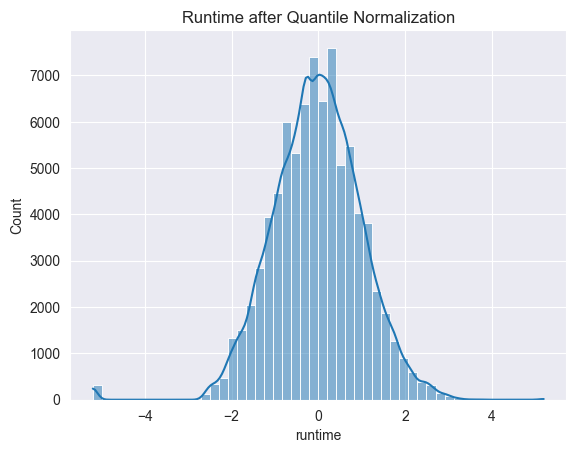

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df['runtime'], bins=50, kde=True)
plt.title("Runtime after Quantile Normalization")
plt.show()

In [46]:
df.info()

df.head(100)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82918 entries, 0 to 82917
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   title                82918 non-null  object  
 1   runtime              82918 non-null  float64 
 2   overview             82129 non-null  object  
 3   genres               81442 non-null  object  
 4   movieId              82918 non-null  int64   
 5   if_blockbuster       82918 non-null  int32   
 6   highly_watched       82918 non-null  int32   
 7   release_year         82918 non-null  float64 
 8   decade               82863 non-null  category
 9   highly_rated         82918 non-null  int64   
 10  engagement_score     82918 non-null  float64 
 11  semantic_keywords    82918 non-null  object  
 12  cast_importance      82918 non-null  float64 
 13  top_cast_members     82918 non-null  object  
 14  director_score       82918 non-null  float64 
 15  top_directors      

,title,runtime,overview,genres,movieId,if_blockbuster,highly_watched,release_year,decade,highly_rated,engagement_score,semantic_keywords,cast_importance,top_cast_members,director_score,top_directors,has_keywords,has_cast,has_director,lemmatized_keywords,overview_spacy,tokens_combined,cleaned_title
0,Inception,1.942703,"Cobb, a skilled thief who commits corporate es...","Action, Science Fiction, Adventure",79132,1,1,2010.0,"[2010, 2020)",1,4.591432,"[kidnapping, allegory, manipulation, mission, ...",2.899632,"[Leonardo DiCaprio, Tom Hardy, Joseph Gordon-L...",2.653210,[Christopher Nolan],1,1,1,"[kidnapping, allegory, manipulation, mission, ...","[corporate, impossible, implantation, subconsc...","[kidnapping, allegory, manipulation, mission, ...",[_UNKNOWN_]
1,Interstellar,2.432017,The adventures of a group of explorers who mak...,"Adventure, Drama, Science Fiction",109487,1,1,2014.0,"[2010, 2020)",1,5.199338,"[2060s, future, complicated, time warp, earth,...",2.789332,"[Anne Hathaway, Matthew McConaughey, Jessica C...",2.653210,[Christopher Nolan],1,1,1,"[2060s, future, complicated, time warp, earth,...","[human, limitation, travel, vast, distance, vo...","[vast, distance, future, complicated, earth, f...",[_UNKNOWN_]
2,The Dark Knight,2.033104,Batman raises the stakes in his war on crime. ...,"Drama, Action, Crime, Thriller",58559,1,1,2008.0,"[2000, 2010)",1,5.199338,"[crime fighter, world, anti villain, vigilante...",3.099369,"[Christian Bale, Gary Oldman, Morgan Freeman, ...",2.653210,[Christopher Nolan],1,1,1,"[crime fighter, world, anti villain, vigilante...","[joker, partnership, citizen, gordon, street, ...","[rule, partnership, citizen, crime fighter, ba...","[dark, knight]"
3,Avatar,2.256745,"In the 22nd century, a paraplegic Marine is di...","Action, Adventure, Fantasy, Science Fiction",72998,1,1,2009.0,"[2000, 2010)",1,4.123958,"[future, culture clash, joyful, space travel, ...",2.512635,"[Zoe Saldaña, Sigourney Weaver, Michelle Rodri...",2.304477,[James Cameron],1,1,1,"[future, culture clash, joyful, space travel, ...","[alien, unique, mission, pandora, moon, order,...","[future, joyful, culture clash, mission, space...",[avatar]
4,The Avengers,1.824556,When an unexpected enemy emerges and threatens...,"Science Fiction, Action, Adventure",89745,1,1,2012.0,"[2010, 2020)",1,5.199338,"[assembly, required, shield, based on comic, s...",5.199338,"[Scarlett Johansson, Chris Hemsworth, Chris Ev...",1.817788,[Joss Whedon],1,1,1,"[assembly, required, shield, based comic, supe...","[international, unexpected, security, brink, d...","[international, unexpected, marvel cinematic u...",[avengers]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,The Empire Strikes Back,1.358913,"The epic saga continues as Luke Skywalker, in ...","Adventure, Action, Science Fiction",1196,1,1,1980.0,"[1980, 1990)",1,3.003738,"[rebellion, snowstorm, space colony, swamp, ar...",1.826226,"[Harrison Ford, Anthony Daniels, Frank Oz, Mar...",0.704639,[Irvin Kershner],1,1,1,"[rebellion, snowstorm, space colony, swamp, ar...","[leia, luke, despair, determined, empire, skyw...","[luke, despair, determined, android, space ope...",[empire]
96,Shrek,-0.276998,It ain't easy bein' green -- especially if you...,"Animation, Comedy, Fantasy, Adventure, Family",4306,1,1,2001.0,"[2000, 2010)",1,3.144047,"[magic, prince, robin hood, liberation, enchan...",2.695707,"[Eddie Murphy, Cameron Diaz, Mike Myers, Vince...",1.599158,"[Andrew Adamson, Vicky Jenson]",1,1,1,"[magic, prince, robin hood, liberation, enchan...","[compatriot, mission, smelly, fire, green, wis...","[magic, mission, prince, robin hood, fire, lib...",[shrek]
97,Ratatouille,0.908975,"Remy, a resident of Paris, appreciates good fo...","Animation, Comedy, Family, Fantasy",50872,1,1,2007.0,"[2000, 2010)",1,3.133301,"[sewer, river, expensive restaurant, confidenc...",1.566170,"[Will Arnett, Peter Sohn, Brad Garrett, Ian Ho...",1.685018,[Brad Bird],1,1,1,"[se

# Normalizacja danych numerycznych

In [47]:
# from sklearn.preprocessing import MinMaxScaler
#
# scaler = MinMaxScaler()
#
# columns_to_normalize = ['engagement_score', 'cast_importance', 'director_score', 'release_year','runtime']
#
# df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])
#
# print(df[columns_to_normalize].head())

In [48]:
df.head(10)

,title,runtime,overview,genres,movieId,if_blockbuster,highly_watched,release_year,decade,highly_rated,engagement_score,semantic_keywords,cast_importance,top_cast_members,director_score,top_directors,has_keywords,has_cast,has_director,lemmatized_keywords,overview_spacy,tokens_combined,cleaned_title
0,Inception,1.942703,"Cobb, a skilled thief who commits corporate es...","Action, Science Fiction, Adventure",79132,1,1,2010.0,"[2010, 2020)",1,4.591432,"[kidnapping, allegory, manipulation, mission, ...",2.899632,"[Leonardo DiCaprio, Tom Hardy, Joseph Gordon-L...",2.653210,[Christopher Nolan],1,1,1,"[kidnapping, allegory, manipulation, mission, ...","[corporate, impossible, implantation, subconsc...","[kidnapping, allegory, manipulation, mission, ...",[_UNKNOWN_]
1,Interstellar,2.432017,The adventures of a group of explorers who mak...,"Adventure, Drama, Science Fiction",109487,1,1,2014.0,"[2010, 2020)",1,5.199338,"[2060s, future, complicated, time warp, earth,...",2.789332,"[Anne Hathaway, Matthew McConaughey, Jessica C...",2.653210,[Christopher Nolan],1,1,1,"[2060s, future, complicated, time warp, earth,...","[human, limitation, travel, vast, distance, vo...","[vast, distance, future, complicated, earth, f...",[_UNKNOWN_]
2,The Dark Knight,2.033104,Batman raises the stakes in his war on crime. ...,"Drama, Action, Crime, Thriller",58559,1,1,2008.0,"[2000, 2010)",1,5.199338,"[crime fighter, world, anti villain, vigilante...",3.099369,"[Christian Bale, Gary Oldman, Morgan Freeman, ...",2.653210,[Christopher Nolan],1,1,1,"[crime fighter, world, anti villain, vigilante...","[joker, partnership, citizen, gordon, street, ...","[rule, partnership, citizen, crime fighter, ba...","[dark, knight]"
3,Avatar,2.256745,"In the 22nd century, a paraplegic Marine is di...","Action, Adventure, Fantasy, Science Fiction",72998,1,1,2009.0,"[2000, 2010)",1,4.123958,"[future, culture clash, joyful, space travel, ...",2.512635,"[Zoe Saldaña, Sigourney Weaver, Michelle Rodri...",2.304477,[James Cameron],1,1,1,"[future, culture clash, joyful, space travel, ...","[alien, unique, mission, pandora, moon, order,...","[future, joyful, culture clash, mission, space...",[avatar]
4,The Avengers,1.824556,When an unexpected enemy emerges and threatens...,"Science Fiction, Action, Adventure",89745,1,1,2012.0,"[2010, 2020)",1,5.199338,"[assembly, required, shield, based on comic, s...",5.199338,"[Scarlett Johansson, Chris Hemsworth, Chris Ev...",1.817788,[Joss Whedon],1,1,1,"[assembly, required, shield, based comic, supe...","[international, unexpected, security, brink, d...","[international, unexpected, marvel cinematic u...",[avengers]
5,Deadpool,0.778225,The origin story of former Special Forces oper...,"Action, Adventure, Comedy",122904,1,1,2016.0,"[2010, 2020)",1,3.971211,"[beginning, ending, duringcreditsstinger, merc...",2.270731,"[Ryan Reynolds, T.J. Miller, Karan Soni, Ed Sk...",1.644682,[_UNKNOWN_],1,1,1,"[beginning, ending, duringcreditsstinger, merc...","[wilson, ability, sense, dark, accelerated, ro...","[beginning, wilson, ability, sense, dark, rogu...",[deadpool]
6,Avengers: Infinity War,1.962691,As the Avengers and their allies have continue...,"Adventure, Action, Science Fiction",122912,1,1,2018.0,"[2010, 2020)",1,5.199338,"[cosmic, magic, super power, based on comic, s...",5.199338,"[Scarlett Johansson, Chris Hemsworth, Chris Ev...",2.272505,"[Anthony Russo, Joe Russo]",1,1,1,"[cosmic, magic, super power, based comic, supe...","[intergalactic, uncertain, earth, thano, goal,...","[magic, intergalactic, uncertain, earth, marve...","[infinity, war]"
7,Fight Club,1.750222,A ticking-time-bomb insomniac and a slippery s...,Drama,2959,1,1,1999.0,"[1990, 2000)",1,3.936440,"[soap, mischief, nihilism, alter ego, fight, b...",2.443213,"[Brad Pitt, Edward Norton, Helena Bonham Carter]",2.478370,[David Fincher],1,1,1,"[soap, mischief, nihilism, alter ego, fight, b...","[soap, shocking, slippery, insomniac, form, co...","[soap, mischief, nihilism, shocking, dual id

# Enkodowanie wartosci z kategoriami

In [49]:
# from sklearn.preprocessing import MultiLabelBinarizer
#
# def encode_using_mlb(df, column_name):
#     print(f'Shape before encoding {column_name}: {df.shape}')
#     mlb = MultiLabelBinarizer()
#     encoded = mlb.fit_transform(df[column_name])
#     encoded = pd.DataFrame(encoded, columns=mlb.classes_)
#
#     df = df.reset_index(drop=True)
#     encoded = encoded.reset_index(drop=True)
#     df = df.drop(columns=column_name)
#     df = pd.concat([df, encoded], axis=1)
#     print(f'Shape after encoding {column_name}: {df.shape}')
#
#     return df

df['genre_list'] = df['genres'].str.split(', ')
df = df.drop(columns='genres')
df['genre_list'] = df['genre_list'].fillna('').apply(lambda x: [] if x == '' else x)

# df = encode_using_mlb(df, 'genre_list')

all_genres = sorted(set(g for sublist in df['genre_list'] for g in sublist if g))
genre_to_idx = {g: i for i, g in enumerate(all_genres)}
genre_to_idx['_UNKNOWN_'] = len(genre_to_idx)

df['genre_ids'] = df['genre_list'].apply(
    lambda genres: [genre_to_idx.get(g, genre_to_idx['_UNKNOWN_']) for g in genres] if genres else [genre_to_idx['_UNKNOWN_']]
)

df = df.drop(columns='genre_list')

In [50]:
df = pd.get_dummies(df, columns=['decade'], prefix='decade')

In [51]:
print(df.head())

             title   runtime  \
0        Inception  1.942703   
1     Interstellar  2.432017   
2  The Dark Knight  2.033104   
3           Avatar  2.256745   
4     The Avengers  1.824556   

                                            overview  movieId  if_blockbuster  \
0  Cobb, a skilled thief who commits corporate es...    79132               1   
1  The adventures of a group of explorers who mak...   109487               1   
2  Batman raises the stakes in his war on crime. ...    58559               1   
3  In the 22nd century, a paraplegic Marine is di...    72998               1   
4  When an unexpected enemy emerges and threatens...    89745               1   

   highly_watched  release_year  highly_rated  engagement_score  \
0               1        2010.0             1          4.591432   
1               1        2014.0             1          5.199338   
2               1        2008.0             1          5.199338   
3               1        2009.0             1       

# Enkodowanie wartości tekstowych

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82918 entries, 0 to 82917
Data columns (total 36 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   title                82918 non-null  object 
 1   runtime              82918 non-null  float64
 2   overview             82129 non-null  object 
 3   movieId              82918 non-null  int64  
 4   if_blockbuster       82918 non-null  int32  
 5   highly_watched       82918 non-null  int32  
 6   release_year         82918 non-null  float64
 7   highly_rated         82918 non-null  int64  
 8   engagement_score     82918 non-null  float64
 9   semantic_keywords    82918 non-null  object 
 10  cast_importance      82918 non-null  float64
 11  top_cast_members     82918 non-null  object 
 12  director_score       82918 non-null  float64
 13  top_directors        82918 non-null  object 
 14  has_keywords         82918 non-null  int64  
 15  has_cast             82918 non-null 

In [53]:
from collections import Counter

TOP_N = 10000 # WE SETUP HOW MANY FEATURES MATTERS (INSTEAD OF TF-IDF)

all_tokens = [token for sublist in df["tokens_combined"] for token in sublist]
token_counts = Counter(all_tokens)
common_tokens = set([token for token, _ in token_counts.most_common(TOP_N)])

common_tokens.add("_UNKNOWN_")
df["filtered_tokens"] = df["tokens_combined"].apply(
    lambda tokens: [t for t in tokens if t in common_tokens] if isinstance(tokens, list) else ["_UNKNOWN_"]
)

In [54]:
df['cleaned_title'] = df['cleaned_title'].apply(
    lambda x: x if isinstance(x, list) and len(x) > 0 else ['_UNKNOWN_']
)

In [55]:
df['text_tokens'] = df.apply(
    lambda row: row['filtered_tokens'] + row['cleaned_title'], axis=1
)

assert df['text_tokens'].apply(lambda x: len(x) > 0).all(), "PUSTE TOKENY!"

In [56]:
print(f"_UNKNOWN_' in text_tokens: {(df['text_tokens'].apply(lambda x: '_UNKNOWN_' in x).mean() * 100):.2f}%")

_UNKNOWN_' in text_tokens: 16.42%


In [57]:
from gensim.models import Word2Vec

sentences = df["text_tokens"].tolist()
sentences = [s for s in sentences if s]
sentences.append(["_UNKNOWN_"])

own_model = Word2Vec(
    sentences=sentences,
    vector_size=300,
    window=5,
    min_count=1,
    workers=4,
    sg=1
)


In [58]:
# TOKENIZING AND CREATING VECTORS FOR LEMMATIZED_KEYWORDS

def average_vector(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else model.wv["_UNKNOWN_"]

df["text_embedded"] = df["text_tokens"].apply(lambda tokens: average_vector(tokens, own_model))


In [59]:
from sklearn.metrics.pairwise import cosine_similarity

def show_similar_movies(df, movie_id, top_n=10):
    from sklearn.metrics.pairwise import cosine_similarity
    import numpy as np

    if 'text_embedded' not in df.columns:
        raise ValueError("Brakuje kolumny 'text_embedded'.")

    df['movieId'] = pd.to_numeric(df['movieId'], errors='coerce')

    row = df[df['movieId'] == movie_id]
    if row.empty:
        raise ValueError(f"Nie znaleziono filmu o movieId: {movie_id}")

    vec = row['text_embedded'].values[0]
    if isinstance(vec, list):
        vec = np.array(vec)
    vec = vec.reshape(1, -1)

    all_vecs = np.stack(df['text_embedded'].values)
    similarities = cosine_similarity(vec, all_vecs)[0]

    df['similarity'] = similarities
    title = row['title'].values[0]

    print(f"🎯 Film testowy: {title} (movieId: {movie_id})\n")
    print("🔍 Top podobnych filmów:")

    similar = df[df['movieId'] != movie_id].sort_values('similarity', ascending=False)
    print(similar[['title', 'similarity']].head(top_n).to_string(index=False))


In [60]:
df.head(10)

,title,runtime,overview,movieId,if_blockbuster,highly_watched,release_year,highly_rated,engagement_score,semantic_keywords,cast_importance,top_cast_members,director_score,top_directors,has_keywords,has_cast,has_director,lemmatized_keywords,overview_spacy,tokens_combined,cleaned_title,genre_ids,"decade_[1890, 1900)","decade_[1900, 1910)","decade_[1910, 1920)","decade_[1920, 1930)","decade_[1930, 1940)","decade_[1940, 1950)","decade_[1950, 1960)","decade_[1960, 1970)","decade_[1970, 1980)","decade_[1980, 1990)","decade_[1990, 2000)","decade_[2000, 2010)","decade_[2010, 2020)","decade_[2020, 2030)",filtered_tokens,text_tokens,text_embedded
0,Inception,1.942703,"Cobb, a skilled thief who commits corporate es...",79132,1,1,2010.0,1,4.591432,"[kidnapping, allegory, manipulation, mission, ...",2.899632,"[Leonardo DiCaprio, Tom Hardy, Joseph Gordon-L...",2.653210,[Christopher Nolan],1,1,1,"[kidnapping, allegory, manipulation, mission, ...","[corporate, impossible, implantation, subconsc...","[kidnapping, allegory, manipulation, mission, ...",[_UNKNOWN_],"[0, 14, 1]",False,False,False,False,False,False,False,False,False,False,False,False,True,False,"[kidnapping, allegory, manipulation, mission, ...","[kidnapping, allegory, manipulation, mission, ...","[0.0008652941, 0.06077885, -0.07869467, -0.067..."
1,Interstellar,2.432017,The adventures of a group of explorers who mak...,109487,1,1,2014.0,1,5.199338,"[2060s, future, complicated, time warp, earth,...",2.789332,"[Anne Hathaway, Matthew McConaughey, Jessica C...",2.653210,[Christopher Nolan],1,1,1,"[2060s, future, complicated, time warp, earth,...","[human, limitation, travel, vast, distance, vo...","[vast, distance, future, complicated, earth, f...",[_UNKNOWN_],"[1, 6, 14]",False,False,False,False,False,False,False,False,False,False,False,False,True,False,"[vast, distance, future, complicated, earth, f...","[vast, distance, future, complicated, earth, f...","[-0.010866538, -0.01691181, -0.12693988, -0.04..."
2,The Dark Knight,2.033104,Batman raises the stakes in his war on crime. ...,58559,1,1,2008.0,1,5.199338,"[crime fighter, world, anti villain, vigilante...",3.099369,"[Christian Bale, Gary Oldman, Morgan Freeman, ...",2.653210,[Christopher Nolan],1,1,1,"[crime fighter, world, anti villain, vigilante...","[joker, partnership, citizen, gordon, street, ...","[rule, partnership, citizen, crime fighter, ba...","[dark, knight]","[6, 0, 4, 16]",False,False,False,False,False,False,False,False,False,False,False,True,False,False,"[rule, partnership, citizen, crime fighter, ba...","[rule, partnership, citizen, crime fighter, ba...","[-0.026262647, 0.055052526, -0.08173301, -0.01..."
3,Avatar,2.256745,"In the 22nd century, a paraplegic Marine is di...",72998,1,1,2009.0,1,4.123958,"[future, culture clash, joyful, space travel, ...",2.512635,"[Zoe Saldaña, Sigourney Weaver, Michelle Rodri...",2.304477,[James Cameron],1,1,1,"[future, culture clash, joyful, space travel, ...","[alien, unique, mission, pandora, moon, order,...","[future, joyful, culture clash, mission, space...",[avatar],"[0, 1, 8, 14]",False,False,False,False,False,False,False,False,False,False,False,True,False,False,"[future, joyful, culture clash, mission, space...","[future, joyful, culture clash, mission, space...","[0.0031084684, -0.032840427, -0.12393689, -0.0..."
4,The Avengers,1.824556,When an unexpected enemy emerges and threatens...,89745,1,1,2012.0,1,5.199338,"[assembly, required, shield, based on comic, s...",5.199338,"[Scarlett Johansson, Chris Hemsworth, Chris Ev...",1.817788,[Joss Whedon],1,1,1,"[assembly, required, shield, based comic, supe...","[international, unexpected, security, brink, d...","[international, unexpected, marvel cinematic u...",[avengers],"[14, 0, 1]",False,False,False,False,False,False,False,False,False,False,False,False,True,False,"[international, unexpected, marvel cinematic u...","[international, unexpected, marvel cinematic u...","[-0.015282603, 0.00047473708, -0.11172164, 0.0..."
5,Deadpoo

In [61]:
show_similar_movies(df, movie_id=296, top_n=5)
df.drop(columns=["similarity"], inplace=True, errors="ignore")

🎯 Film testowy: Pulp Fiction (movieId: 296)

🔍 Top podobnych filmów:
                title  similarity
         Tango & Cash    0.966620
          Miami Blues    0.965709
A Piece of the Action    0.964034
              Payback    0.963025
       My Blue Heaven    0.962023


In [62]:
# def get_average_w2v_embedding(title_tokens, model):
#     vectors = [model.wv[word] for word in title_tokens if word in model.wv]
#     return np.mean(vectors, axis=0) if vectors else model.wv["_UNKNOWN_"]
#
# df['title_embedded'] = df['cleaned_title'].apply(lambda x: get_average_w2v_embedding(x, own_model))
#
# print(df[['title', 'title_embedded']].head(10))

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82918 entries, 0 to 82917
Data columns (total 39 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   title                82918 non-null  object 
 1   runtime              82918 non-null  float64
 2   overview             82129 non-null  object 
 3   movieId              82918 non-null  int64  
 4   if_blockbuster       82918 non-null  int32  
 5   highly_watched       82918 non-null  int32  
 6   release_year         82918 non-null  float64
 7   highly_rated         82918 non-null  int64  
 8   engagement_score     82918 non-null  float64
 9   semantic_keywords    82918 non-null  object 
 10  cast_importance      82918 non-null  float64
 11  top_cast_members     82918 non-null  object 
 12  director_score       82918 non-null  float64
 13  top_directors        82918 non-null  object 
 14  has_keywords         82918 non-null  int64  
 15  has_cast             82918 non-null 

In [64]:
# FALLBACK FOR VECTORS THAT EQUALS 0 (NOT NEEDED WHEN WE USE FLAG _UNKNOWN_)

# import numpy as np
#
# def get_fallback_vector(column):
#     vectors = np.stack(column[column.apply(lambda v: np.any(v))].values)
#     return np.mean(vectors, axis=0)
#
# fallback_title = get_fallback_vector(df['title_embedded'])
# fallback_combined = get_fallback_vector(df['keywords_embedded'])
#
# df['title_embedded'] = df['title_embedded'].apply(
#     lambda vec: vec if np.any(vec) else fallback_title
# )
#
# df['keywords_embedded'] = df['keywords_embedded'].apply(
#     lambda vec: vec if np.any(vec) else fallback_combined
# )

In [65]:
actors = ["_UNKNOWN_"] + sorted(set(df['top_cast_members'].explode()))
directors = ["_UNKNOWN_"] + sorted(set(df['top_directors'].explode()))

actor_to_idx = {actor: idx for idx, actor in enumerate(actors)}
director_to_idx = {director: idx for idx, director in enumerate(directors)}

def encode_members(members, member_to_idx):
    return [member_to_idx.get(member, 0) for member in members]  # 0 = _UNKNOWN_

df['actor_ids'] = df['top_cast_members'].apply(lambda x: encode_members(x, actor_to_idx))
df['director_ids'] = df['top_directors'].apply(lambda x: encode_members(x, director_to_idx))

print(df[['title', 'actor_ids', 'director_ids']].head(10))

# actors = df['top_cast_members'].explode().unique()
# directors = df['top_directors'].explode().unique()
#
# actor_to_idx = {actor: idx for idx, actor in enumerate(actors)}
# director_to_idx = {director: idx for idx, director in enumerate(directors)}
#
# def encode_members(members, member_to_idx):
#     return [member_to_idx.get(member, -1) for member in members]
#
# df['actor_ids'] = df['top_cast_members'].apply(lambda x: encode_members(x, actor_to_idx))
# df['director_ids'] = df['top_directors'].apply(lambda x: encode_members(x, director_to_idx))
#
# # self.actor_embedding = nn.Embedding(num_actors, 50)
# # embedded = self.actor_embedding(actor_ids)
#
# print(df[['title', 'actor_ids', 'director_ids']].head(10))

                     title                         actor_ids director_ids
0                Inception   [6454, 10631, 5457, 1952, 5950]        [797]
1             Interstellar    [659, 7298, 4974, 10576, 5292]        [797]
2          The Dark Knight    [1867, 3519, 7812, 1952, 4010]        [797]
3                   Avatar   [11434, 9935, 7629, 9574, 3709]       [2026]
4             The Avengers    [9686, 1839, 1834, 9161, 4923]       [2496]
5                 Deadpool         [9472, 10289, 5752, 2796]       [5144]
6   Avengers: Infinity War    [9686, 1839, 1834, 9161, 7109]  [331, 2279]
7               Fight Club                [1278, 2862, 4040]       [1008]
8  Guardians of the Galaxy  [1282, 1854, 10947, 2608, 11434]       [2041]
9             Pulp Fiction  [9597, 1416, 5349, 10822, 10554]       [3866]


In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82918 entries, 0 to 82917
Data columns (total 41 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   title                82918 non-null  object 
 1   runtime              82918 non-null  float64
 2   overview             82129 non-null  object 
 3   movieId              82918 non-null  int64  
 4   if_blockbuster       82918 non-null  int32  
 5   highly_watched       82918 non-null  int32  
 6   release_year         82918 non-null  float64
 7   highly_rated         82918 non-null  int64  
 8   engagement_score     82918 non-null  float64
 9   semantic_keywords    82918 non-null  object 
 10  cast_importance      82918 non-null  float64
 11  top_cast_members     82918 non-null  object 
 12  director_score       82918 non-null  float64
 13  top_directors        82918 non-null  object 
 14  has_keywords         82918 non-null  int64  
 15  has_cast             82918 non-null 

In [67]:
df.head(87000)

,title,runtime,overview,movieId,if_blockbuster,highly_watched,release_year,highly_rated,engagement_score,semantic_keywords,cast_importance,top_cast_members,director_score,top_directors,has_keywords,has_cast,has_director,lemmatized_keywords,overview_spacy,tokens_combined,cleaned_title,genre_ids,"decade_[1890, 1900)","decade_[1900, 1910)","decade_[1910, 1920)","decade_[1920, 1930)","decade_[1930, 1940)","decade_[1940, 1950)","decade_[1950, 1960)","decade_[1960, 1970)","decade_[1970, 1980)","decade_[1980, 1990)","decade_[1990, 2000)","decade_[2000, 2010)","decade_[2010, 2020)","decade_[2020, 2030)",filtered_tokens,text_tokens,text_embedded,actor_ids,director_ids
0,Inception,1.942703,"Cobb, a skilled thief who commits corporate es...",79132,1,1,2010.0,1,4.591432,"[kidnapping, allegory, manipulation, mission, ...",2.899632,"[Leonardo DiCaprio, Tom Hardy, Joseph Gordon-L...",2.653210,[Christopher Nolan],1,1,1,"[kidnapping, allegory, manipulation, mission, ...","[corporate, impossible, implantation, subconsc...","[kidnapping, allegory, manipulation, mission, ...",[_UNKNOWN_],"[0, 14, 1]",False,False,False,False,False,False,False,False,False,False,False,False,True,False,"[kidnapping, allegory, manipulation, mission, ...","[kidnapping, allegory, manipulation, mission, ...","[0.0008652941, 0.06077885, -0.07869467, -0.067...","[6454, 10631, 5457, 1952, 5950]",[797]
1,Interstellar,2.432017,The adventures of a group of explorers who mak...,109487,1,1,2014.0,1,5.199338,"[2060s, future, complicated, time warp, earth,...",2.789332,"[Anne Hathaway, Matthew McConaughey, Jessica C...",2.653210,[Christopher Nolan],1,1,1,"[2060s, future, complicated, time warp, earth,...","[human, limitation, travel, vast, distance, vo...","[vast, distance, future, complicated, earth, f...",[_UNKNOWN_],"[1, 6, 14]",False,False,False,False,False,False,False,False,False,False,False,False,True,False,"[vast, distance, future, complicated, earth, f...","[vast, distance, future, complicated, earth, f...","[-0.010866538, -0.01691181, -0.12693988, -0.04...","[659, 7298, 4974, 10576, 5292]",[797]
2,The Dark Knight,2.033104,Batman raises the stakes in his war on crime. ...,58559,1,1,2008.0,1,5.199338,"[crime fighter, world, anti villain, vigilante...",3.099369,"[Christian Bale, Gary Oldman, Morgan Freeman, ...",2.653210,[Christopher Nolan],1,1,1,"[crime fighter, world, anti villain, vigilante...","[joker, partnership, citizen, gordon, street, ...","[rule, partnership, citizen, crime fighter, ba...","[dark, knight]","[6, 0, 4, 16]",False,False,False,False,False,False,False,False,False,False,False,True,False,False,"[rule, partnership, citizen, crime fighter, ba...","[rule, partnership, citizen, crime fighter, ba...","[-0.026262647, 0.055052526, -0.08173301, -0.01...","[1867, 3519, 7812, 1952, 4010]",[797]
3,Avatar,2.256745,"In the 22nd century, a paraplegic Marine is di...",72998,1,1,2009.0,1,4.123958,"[future, culture clash, joyful, space travel, ...",2.512635,"[Zoe Saldaña, Sigourney Weaver, Michelle Rodri...",2.304477,[James Cameron],1,1,1,"[future, culture clash, joyful, space travel, ...","[alien, unique, mission, pandora, moon, order,...","[future, joyful, culture clash, mission, space...",[avatar],"[0, 1, 8, 14]",False,False,False,False,False,False,False,False,False,False,False,True,False,False,"[future, joyful, culture clash, mission, space...","[future, joyful, culture clash, mission, space...","[0.0031084684, -0.032840427, -0.12393689, -0.0...","[11434, 9935, 7629, 9574, 3709]",[2026]
4,The Avengers,1.824556,When an unexpected enemy emerges and threatens...,89745,1,1,2012.0,1,5.199338,"[assembly, required, shield, based on comic, s...",5.199338,"[Scarlett Johansson, Chris Hemsworth, Chris Ev...",1.817788,[Joss Whedon],1,1,1,"[assembly, required, shield, based comic, supe...","[international, unexpected, security, brink, d...","[international, unexpected, marvel cinematic u...",[avengers],"[14, 0, 1]",False,False,False,False,False,False,False,False,False,False,False,

In [68]:
count_result = count_zeros_and_empty(df)
print(count_result)

{'title': {'empty_strings': 0}, 'runtime': {'zeros': 0}, 'movieId': {'zeros': 0}, 'if_blockbuster': {'zeros': 80654}, 'highly_watched': {'zeros': 75372}, 'release_year': {'zeros': 0}, 'highly_rated': {'zeros': 74668}, 'engagement_score': {'zeros': 0}, 'cast_importance': {'zeros': 0}, 'director_score': {'zeros': 0}, 'has_keywords': {'zeros': 25554}, 'has_cast': {'zeros': 8482}, 'has_director': {'zeros': 8482}, 'decade_[1890, 1900)': {'zeros': 82708}, 'decade_[1900, 1910)': {'zeros': 82623}, 'decade_[1910, 1920)': {'zeros': 82540}, 'decade_[1920, 1930)': {'zeros': 82225}, 'decade_[1930, 1940)': {'zeros': 80655}, 'decade_[1940, 1950)': {'zeros': 80476}, 'decade_[1950, 1960)': {'zeros': 79692}, 'decade_[1960, 1970)': {'zeros': 78890}, 'decade_[1970, 1980)': {'zeros': 77434}, 'decade_[1980, 1990)': {'zeros': 76880}, 'decade_[1990, 2000)': {'zeros': 75146}, 'decade_[2000, 2010)': {'zeros': 68001}, 'decade_[2010, 2020)': {'zeros': 55767}, 'decade_[2020, 2030)': {'zeros': 74952}}


# Zapisanie pliku do PARQUET i finalne przygotowanie danych

In [69]:
movie = df.loc[df['title'] == 'Gladiator']
print(movie)

          title   runtime                                           overview  \
76    Gladiator  2.085356  In the year 180, the death of emperor Marcus A...   
8902  Gladiator  0.464007  Tommy Riley has moved with his dad to Chicago ...   

      movieId  if_blockbuster  highly_watched  release_year  highly_rated  \
76       3578               1               1        2000.0             1   
8902     8132               0               1        1992.0             1   

      engagement_score                                  semantic_keywords  \
76            3.123685  [2nd century, senate, rise, parent child relat...   
8902          1.603455  [illinois, blood splatter, tommy, riley, owns,...   

      cast_importance                                   top_cast_members  \
76           2.298136  [Djimon Hounsou, Joaquin Phoenix, Russell Crow...   
8902         0.830594                  [Cuba Gooding Jr., Brian Dennehy]   

      director_score       top_directors  has_keywords  has_cast  

In [70]:
columns_to_drop = [
    'semantic_keywords',
    'lemmatized_keywords',
    'overview',
    'overview_spacy',
    'tokens_combined',
    'filtered_tokens',
    'title',
    'cleaned_title',
    'top_cast_members',
    'top_directors',
    'text_tokens',
    'release_year'
]

df = df.drop(columns=columns_to_drop)
print('Final shape:', df.shape)

Final shape: (82918, 29)


In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82918 entries, 0 to 82917
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   runtime              82918 non-null  float64
 1   movieId              82918 non-null  int64  
 2   if_blockbuster       82918 non-null  int32  
 3   highly_watched       82918 non-null  int32  
 4   highly_rated         82918 non-null  int64  
 5   engagement_score     82918 non-null  float64
 6   cast_importance      82918 non-null  float64
 7   director_score       82918 non-null  float64
 8   has_keywords         82918 non-null  int64  
 9   has_cast             82918 non-null  int64  
 10  has_director         82918 non-null  int64  
 11  genre_ids            82918 non-null  object 
 12  decade_[1890, 1900)  82918 non-null  bool   
 13  decade_[1900, 1910)  82918 non-null  bool   
 14  decade_[1910, 1920)  82918 non-null  bool   
 15  decade_[1920, 1930)  82918 non-null 

In [72]:
embedding_columns = ['text_embedded'] # 'title_embedded'

for col in embedding_columns:
    def process(x):
        if hasattr(x, 'detach'):
            x = x.detach().cpu().numpy()
        x = np.array(x, dtype=np.float32)
        if len(x.shape) > 1:
            x = x.mean(axis=0)
        return x

    df[col] = df[col].apply(process)

In [73]:
df.head(10)

,runtime,movieId,if_blockbuster,highly_watched,highly_rated,engagement_score,cast_importance,director_score,has_keywords,has_cast,has_director,genre_ids,"decade_[1890, 1900)","decade_[1900, 1910)","decade_[1910, 1920)","decade_[1920, 1930)","decade_[1930, 1940)","decade_[1940, 1950)","decade_[1950, 1960)","decade_[1960, 1970)","decade_[1970, 1980)","decade_[1980, 1990)","decade_[1990, 2000)","decade_[2000, 2010)","decade_[2010, 2020)","decade_[2020, 2030)",text_embedded,actor_ids,director_ids
0,1.942703,79132,1,1,1,4.591432,2.899632,2.653210,1,1,1,"[0, 14, 1]",False,False,False,False,False,False,False,False,False,False,False,False,True,False,"[0.0008652941, 0.06077885, -0.07869467, -0.067...","[6454, 10631, 5457, 1952, 5950]",[797]
1,2.432017,109487,1,1,1,5.199338,2.789332,2.653210,1,1,1,"[1, 6, 14]",False,False,False,False,False,False,False,False,False,False,False,False,True,False,"[-0.010866538, -0.01691181, -0.12693988, -0.04...","[659, 7298, 4974, 10576, 5292]",[797]
2,2.033104,58559,1,1,1,5.199338,3.099369,2.653210,1,1,1,"[6, 0, 4, 16]",False,False,False,False,False,False,False,False,False,False,False,True,False,False,"[-0.026262647, 0.055052526, -0.08173301, -0.01...","[1867, 3519, 7812, 1952, 4010]",[797]
3,2.256745,72998,1,1,1,4.123958,2.512635,2.304477,1,1,1,"[0, 1, 8, 14]",False,False,False,False,False,False,False,False,False,False,False,True,False,False,"[0.0031084684, -0.032840427, -0.12393689, -0.0...","[11434, 9935, 7629, 9574, 3709]",[2026]
4,1.824556,89745,1,1,1,5.199338,5.199338,1.817788,1,1,1,"[14, 0, 1]",False,False,False,False,False,False,False,False,False,False,False,False,True,False,"[-0.015282603, 0.00047473708, -0.11172164, 0.0...","[9686, 1839, 1834, 9161, 4923]",[2496]
5,0.778225,122904,1,1,1,3.971211,2.270731,1.644682,1,1,1,"[0, 1, 3]",False,False,False,False,False,False,False,False,False,False,False,False,True,False,"[0.007300426, -0.021129752, -0.08656983, -0.02...","[9472, 10289, 5752, 2796]",[5144]
6,1.962691,122912,1,1,1,5.199338,5.199338,2.272505,1,1,1,"[1, 0, 14]",False,False,False,False,False,False,False,False,False,False,False,False,True,False,"[0.011270235, -0.03924137, -0.13046095, 0.0415...","[9686, 1839, 1834, 9161, 7109]","[331, 2279]"
7,1.750222,2959,1,1,1,3.936440,2.443213,2.478370,1,1,1,[6],False,False,False,False,False,False,False,False,False,False,True,False,False,False,"[-0.016449817, 0.0064580794, -0.045379233, -0....","[1278, 2862, 4040]",[1008]
8,1.278137,112852,1,1,1,3.554852,3.595284,2.164474,1,1,1,"[0, 14, 1]",False,False,False,False,False,False,False,False,False,False,False,False,True,False,"[-0.018016843, 0.03179344, -0.11795669, 0.0364...","[1282, 1854, 10947, 2608, 11434]",[2041]
9,2.063775,296,1,1,1,3.998178,2.961178,2.625593,1,1,1,"[16, 4]",False,False,False,False,False,False,False,False,False,False,True,False,False,False,"[-0.053421922, 0.048997603, -0.09004167, -0.05...","[9597, 1416, 5349, 10822, 10554]",[3866]


In [74]:
cols = df.columns.tolist()
cols.remove('movieId')
new_order = ['movieId'] + cols

df_final = df[new_order]

In [75]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82918 entries, 0 to 82917
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   movieId              82918 non-null  int64  
 1   runtime              82918 non-null  float64
 2   if_blockbuster       82918 non-null  int32  
 3   highly_watched       82918 non-null  int32  
 4   highly_rated         82918 non-null  int64  
 5   engagement_score     82918 non-null  float64
 6   cast_importance      82918 non-null  float64
 7   director_score       82918 non-null  float64
 8   has_keywords         82918 non-null  int64  
 9   has_cast             82918 non-null  int64  
 10  has_director         82918 non-null  int64  
 11  genre_ids            82918 non-null  object 
 12  decade_[1890, 1900)  82918 non-null  bool   
 13  decade_[1900, 1910)  82918 non-null  bool   
 14  decade_[1910, 1920)  82918 non-null  bool   
 15  decade_[1920, 1930)  82918 non-null 

In [76]:
df_final.head(1000)

,movieId,runtime,if_blockbuster,highly_watched,highly_rated,engagement_score,cast_importance,director_score,has_keywords,has_cast,has_director,genre_ids,"decade_[1890, 1900)","decade_[1900, 1910)","decade_[1910, 1920)","decade_[1920, 1930)","decade_[1930, 1940)","decade_[1940, 1950)","decade_[1950, 1960)","decade_[1960, 1970)","decade_[1970, 1980)","decade_[1980, 1990)","decade_[1990, 2000)","decade_[2000, 2010)","decade_[2010, 2020)","decade_[2020, 2030)",text_embedded,actor_ids,director_ids
0,79132,1.942703,1,1,1,4.591432,2.899632,2.653210,1,1,1,"[0, 14, 1]",False,False,False,False,False,False,False,False,False,False,False,False,True,False,"[0.0008652941, 0.06077885, -0.07869467, -0.067...","[6454, 10631, 5457, 1952, 5950]",[797]
1,109487,2.432017,1,1,1,5.199338,2.789332,2.653210,1,1,1,"[1, 6, 14]",False,False,False,False,False,False,False,False,False,False,False,False,True,False,"[-0.010866538, -0.01691181, -0.12693988, -0.04...","[659, 7298, 4974, 10576, 5292]",[797]
2,58559,2.033104,1,1,1,5.199338,3.099369,2.653210,1,1,1,"[6, 0, 4, 16]",False,False,False,False,False,False,False,False,False,False,False,True,False,False,"[-0.026262647, 0.055052526, -0.08173301, -0.01...","[1867, 3519, 7812, 1952, 4010]",[797]
3,72998,2.256745,1,1,1,4.123958,2.512635,2.304477,1,1,1,"[0, 1, 8, 14]",False,False,False,False,False,False,False,False,False,False,False,True,False,False,"[0.0031084684, -0.032840427, -0.12393689, -0.0...","[11434, 9935, 7629, 9574, 3709]",[2026]
4,89745,1.824556,1,1,1,5.199338,5.199338,1.817788,1,1,1,"[14, 0, 1]",False,False,False,False,False,False,False,False,False,False,False,False,True,False,"[-0.015282603, 0.00047473708, -0.11172164, 0.0...","[9686, 1839, 1834, 9161, 4923]",[2496]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,5389,-0.754664,1,1,1,2.405705,1.511651,1.390983,1,1,1,"[2, 1, 3, 7, 6]",False,False,False,False,False,False,False,False,False,False,False,True,False,False,"[0.020610543, 0.0019066618, -0.040885072, 0.03...","[7264, 4533, 9041]",[2648]
996,1884,1.142483,0,1,1,2.171492,1.910456,1.822531,1,1,1,"[1, 6, 3]",False,False,False,False,False,False,False,False,False,False,True,False,False,False,"[0.0017100944, 0.05054285, -0.025524449, -0.01...","[5362, 10591, 1054, 2121]",[4671]
997,113378,0.232930,1,1,1,1.937074,1.939330,1.801255,1,1,1,"[6, 14]",False,False,False,False,False,False,False,False,False,False,False,False,True,False,"[0.0124822855, 0.007138936, -0.11793309, -0.00...","[7442, 4828, 5858, 1323, 302]",[3826]
998,733,1.710968,1,1,1,2.202957,2.083528,2.509081,1,1,1,"[0, 1, 16]",False,False,False,False,False,False,False,False,False,False,True,False,False,False,"[0.005211933, 0.03213417, -0.085695535, -0.050...","[8036, 9714, 2788, 2396, 5219]",[3231]


In [81]:
df_final.to_parquet('Movies_clean_Vec_v4_25keywords.parquet', compression='brotli', index=False)

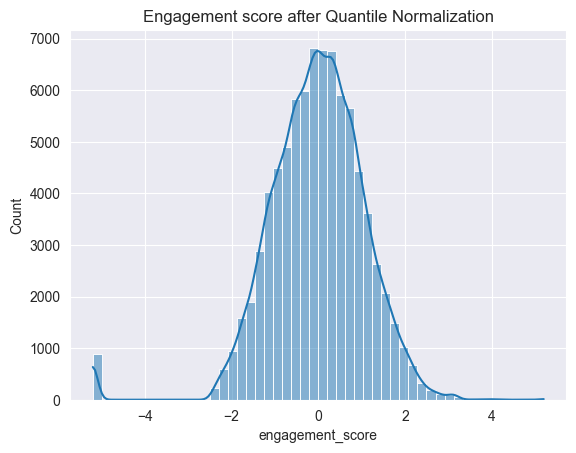

In [82]:
sns.histplot(df['engagement_score'], bins=50, kde=True)
plt.title("Engagement score after Quantile Normalization")
plt.show()